# Collaboration and Competition

---

This notebook shows how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

Importing all necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import random

from collections import namedtuple, deque

from ddpg_multi_agents import Agents

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)

1.4.0



Bad key "text.kerning_factor" on line 4 in
/home/horst/anaconda3/envs/drlnd-4-copy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Start the environment!

In [2]:
env = UnityEnvironment(file_name="/home/horst/ml/udacity/udacity-deep-RL/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
print(brain)

TennisBrain
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The **observation space** consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. 

**Two continuous actions** are available, corresponding to movement toward (or away from) the net, and jumping.

The code cell below prints some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

The next code cell shows how to use the Python API to control the agent(s) and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent(s) moving within the environment. 

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. Train the agent(s) using DDPG

Use [`DDPG`](https://arxiv.org/pdf/1509.02971.pdf) to train the agent(s) to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Initialize the agents.

In [6]:
agents = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=12)

The code below will train the agents over 2000 episodes.

/home/horst/anaconda3/envs/drlnd-4-copy/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.03
Episode 900	Average Score: 0.06
Episode 1000	Average Score: 0.06
Episode 1100	Average Score: 0.10
Episode 1200	Average Score: 0.10
Episode 1300	Average Score: 0.06
Episode 1400	Average Score: 0.08
Episode 1500	Average Score: 0.09
Episode 1600	Average Score: 0.12
Episode 1700	Average Score: 0.12
Episode 1800	Average Score: 0.13
Episode 1900	Average Score: 0.74
Episode 1917	Average Score: 1.00
Environment solved in 1917 episodes!	Average Score: 1.00


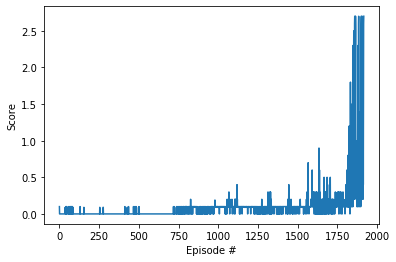

In [7]:
def ddpg_train(n_episodes = 4000, max_t = 1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """

    scores = []                           # list scores from each episode
    scores_deque = deque(maxlen=100)      # last 100 scores
    
    last_mean_score = 0.5

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the next initial state

        agents.reset()                                     # set the noise to zero
        score = np.zeros(num_agents)                       # set score of the episode to zero for each agent
        
        while(True):
            actions = agents.act(states)                           # do a forword pass to get the next action
            env_info = env.step(actions)[brain_name]               # send the action to the environment
            next_states = env_info.vector_observations             # get the next states
            rewards = env_info.rewards                             # get the rewards
            dones = env_info.local_done                            # see if the episode has finished for any agent

            agents.step(states, actions, rewards, next_states, dones)  # do the training
            
            score += rewards               # update the episode score
            states = next_states           # roll over the state to next time step
            
            # check if done for any agent
            if np.any(dones):
                break

        scores_deque.append(np.max(score)) # save most recent score for the last 100 scores within deque
        scores.append(np.max(score))       # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque) > 1.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
                torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
                break
    return scores

scores = ddpg_train()
            
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch a Smart Agent!

Load the trained weights from file to watch a smart agent!

In [ ]:
# get the trained actor and critec networks 
agents.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        time.sleep(0.05)
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

In [ ]:
env.close()